In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

/tmp/ipykernel_718836/388590871.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import numpy as np
from scipy import stats, spatial
import processing

In [5]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import statsmodels.api as sm

## Performance analysis

### Data prep

In [7]:
words = pd.read_csv('./data/words.csv')

In [9]:
log = pd.read_csv('./data/log_valid_processed.csv')

In [10]:
participants = pd.read_csv('./data/participants_processed.csv', index_col=0)
participants = participants.loc[participants.index.isin(log.participant_id.unique())].copy()

In [11]:
mask = words.ite == 'none'
mask &= words.word_length < 5
mask &= words.freq_category == 'very_common'
mask &= words.iki_letters.notna()

participants['iki_natural'] = words.loc[mask].groupby('participant_id').iki_letters.mean()

# Letter-only speed
mask = words.ite == 'none'
participants['iki_letters'] = words.loc[mask].groupby('participant_id').iki_letters.mean()

# Letters and selection speed
participants['iki_letters_and_ite'] = words.groupby('participant_id').iki_letters_and_ite.mean() 

# Overall speed
iki_overall = log.groupby(['participant_id', 'ts_id']).iki.sum() / log.groupby(['participant_id', 'ts_id']).text_field.last().str.len()
iki_overall = iki_overall.reset_index(name='iki').groupby('participant_id').iki.mean()
participants['iki_overall'] = iki_overall

# Remove NA speeds
participants = participants.dropna(subset=['iki_natural', 'iki_letters', 'iki_letters_and_ite', 'iki_overall']).copy()

# Remove extremely fast speeds (for example, due to outlier backend behaviour)
participants = participants.loc[participants.iki_natural > 75].copy()

# Calculate word suggestion usage
participants['n_predict'] = words.groupby('participant_id').ite.value_counts().unstack()['predict'].fillna(0)
participants['rate_predict'] = words.groupby('participant_id').ite.value_counts(normalize=True).unstack()['predict'].fillna(0)

# Calculate keystrokes per character
mask = log.lev_dist < 10 # Filter out poor LD calculations
participants['KPC'] = log.loc[mask].groupby('participant_id').size() / log.loc[mask].groupby('participant_id').lev_dist.sum()

# Separate into normal and suggestion users
participants.loc[participants.n_predict < 1, 'user_type'] = 'Normal'
participants.loc[participants.n_predict > 5, 'user_type'] = 'Suggestion users'

In [291]:
# Optional: Outlier removal
data = participants.copy()
participants_no_outliers = data[(np.abs(stats.zscore(data['iki_natural'])) < 3)]

                                                          BROWSER   
PARTICIPANT_ID                                                      
782             Mozilla/5.0 (iPad; CPU OS 11_4_1 like Mac OS X...  \
790             Mozilla/5.0 (iPhone; CPU iPhone OS 11_4_1 like...   
792             Mozilla/5.0 (iPhone; CPU iPhone OS 12_0 like M...   
842             Mozilla/5.0 (iPhone; CPU iPhone OS 11_4 like M...   
854             Mozilla/5.0 (iPhone; CPU iPhone OS 11_3 like M...   

               BROWSER_LANGUAGE  DEVICE  SCREEN_W  SCREEN_H  AGE  GENDER   
PARTICIPANT_ID                                                             
782                       en-us  mobile      1024       768   50  female  \
790                       en-us  mobile       414       736   19    male   
792                       en-us  mobile       375       667   17  female   
842                       en-us  mobile       375       667   27  female   
854                       en-us  mobile       414       736 

### Demographics

In [12]:
print("AGE mean and std")
print("median: ", participants.AGE.median())
print(participants.AGE.describe())
print(" ")
print("Participants under 18")
print(participants.loc[participants.AGE < 18, "AGE"].count())
print(" ")
print("GENDER")
print("female: ", participants.loc[participants.GENDER == 'female', 'GENDER'].count())
print("male: ", participants.loc[participants.GENDER == 'male', 'GENDER'].count())
print("not disclosed: ", participants.loc[participants.GENDER == 'none', 'GENDER'].count())
print("PERCENTAGE")
print(participants["GENDER"].value_counts(normalize=True) * 100)
print(" ")
print("OS")
print("Android: ", participants.loc[participants.os == 'Android', 'os'].count())
print("iOS:", participants.loc[participants.os == 'iOS', 'os'].count())
print("percentage: ", participants["os"].value_counts(normalize=True) * 100)

AGE mean and std
median:  21.0
count    15162.000000
mean        22.985028
std          9.063996
min          6.000000
25%         17.000000
50%         21.000000
75%         27.000000
max         61.000000
Name: AGE, dtype: float64
 
Participants under 18
3813
 
GENDER
female:  10565
male:  3762
not disclosed:  835
PERCENTAGE
GENDER
female    69.680781
male      24.812030
none       5.507189
Name: proportion, dtype: float64
 
OS
Android:  1262
iOS: 13900
percentage:  os
iOS        91.67656
Android     8.32344
Name: proportion, dtype: float64


### How many users in each group?

In [281]:
print(participants.user_type.value_counts())
#print(participants_no_outliers.user_type.value_counts())

user_type
Suggestion users    4396
Normal              3926
Name: count, dtype: int64


### What is the mean natural speed of each group?

In [28]:
participants.groupby('user_type').iki_natural.mean().apply(np.reciprocal) * 1000

user_type
Normal              5.664215
Suggestion users    4.957995
Name: iki_natural, dtype: float64

### How does suggestion usage affect typing speed?

In [282]:
# Prepare a display table. Will fill later.
disp = pd.DataFrame(    
    index = ['Normal users', 'Suggestion users', 'Difference (controlled for natural speed)'],
    columns=['Natural speed', 'Letter-only speed', 'Letter-and-selection speed', 'Overall speed']
)

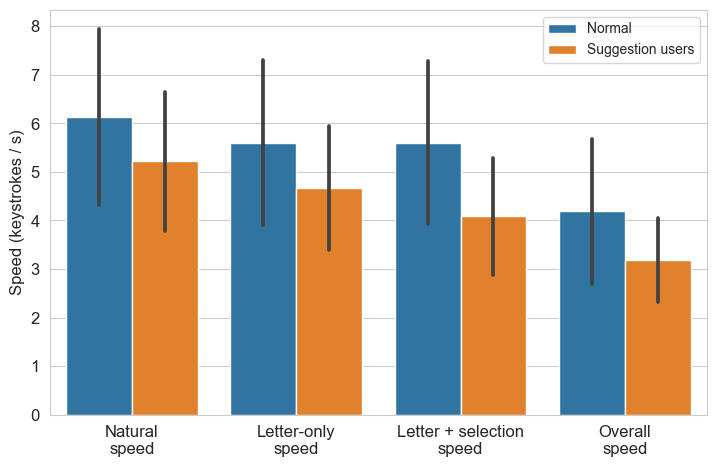

In [283]:
f,ax = plt.subplots(1, 1, figsize=(7, 4.5))

# Data prep
data = participants.copy()
data = data.loc[data.user_type.notna()]
data = data.loc[data.iki_natural.notna()]

data.iki_natural = data.iki_natural.apply(np.reciprocal) * 1000 # Convert iki to speed
data.iki_overall = data.iki_overall.apply(np.reciprocal) * 1000
data.iki_letters = data.iki_letters.apply(np.reciprocal) * 1000
data.iki_letters_and_ite = data.iki_letters_and_ite.apply(np.reciprocal) * 1000

data = data.sort_values('user_type')
data_melt = pd.melt(data[['user_type', 'iki_natural', 'iki_letters', 'iki_letters_and_ite', 'iki_overall']], id_vars='user_type') # Melt (easier to plot this way)

# Plot
sns.barplot(x='variable', y='value', hue='user_type', data=data_melt, ax=ax, errorbar="sd")

ax.set_xlabel('')
ax.set_xticklabels(['Natural\nspeed', 'Letter-only\nspeed', 'Letter + selection\nspeed', 'Overall\nspeed'])
ax.set_ylabel('Speed (keystrokes / s)')
ax.legend(title='User type')

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

ax.legend(title='')

f.tight_layout(pad=0.1)

f.savefig('./figures/bar_typing_speeds.png', dpi=300)

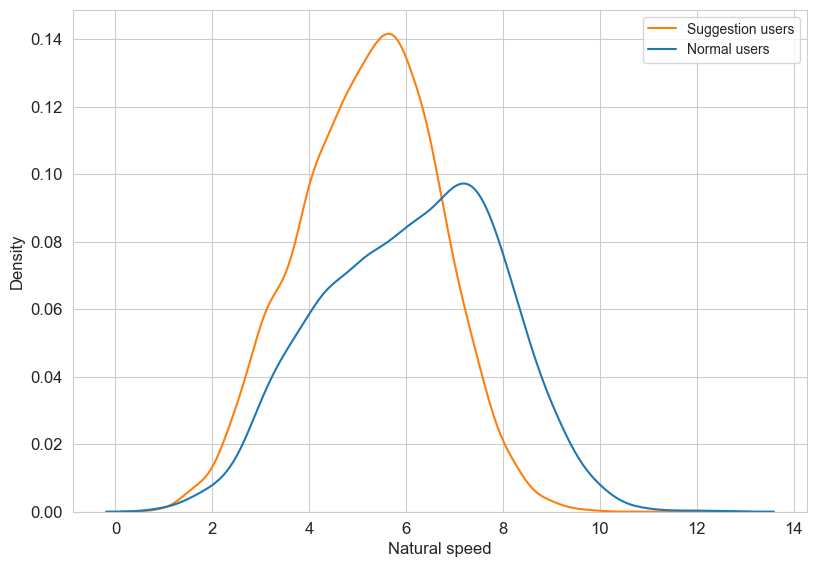

In [246]:
#KDE Plot of natural speed
f,ax = plt.subplots(1, 1, figsize=(8,5.5))

# Data prep
data = participants.copy()
data = data.loc[data.user_type.notna()]
data = data.loc[data.iki_natural.notna()]
data = data.loc[data.iki_overall.notna()]

data.iki_natural = data.iki_natural.apply(np.reciprocal) * 1000 # Convert iki to speed
data.iki_overall = data.iki_overall.apply(np.reciprocal) * 1000 # Convert iki to speed

data = data.sort_values('user_type')
data_melt = pd.melt(data[['user_type', 'iki_natural']], id_vars='user_type')
data_melt = data_melt.drop(columns=['variable'])

# Plot
sns.kdeplot(data=data_melt, x="value", hue="user_type", legend=True, ax=ax)

ax.set_xlabel('Natural speed')
ax.legend(labels=['Suggestion users', 'Normal users'])

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
              ax.get_xticklabels() + ax.get_yticklabels()):
     item.set_fontsize(12)

f.tight_layout(pad=0.1)

f.savefig('./figures/kde_natural_speed.png', dpi=300)

In [284]:
# Display the means
res = data[[
    'user_type',
    'iki_natural',
    'iki_letters',
    'iki_letters_and_ite',
    'iki_overall'
]].groupby('user_type').mean().round(2)

disp.loc['Normal users'] = res.loc['Normal'].apply(str).values
disp.loc['Suggestion users'] = res.loc['Suggestion users'].apply(str).values

# Open parantheses
disp.loc['Normal users'] += '\n('
disp.loc['Suggestion users'] += '\n('

# Display the stderr
res = data[[
    'user_type',
    'iki_natural',
    'iki_letters',
    'iki_letters_and_ite',
    'iki_overall'
]].groupby('user_type').std().round(2)
disp.loc['Normal users'] += res.loc['Normal'].apply(str).values
disp.loc['Suggestion users'] += res.loc['Suggestion users'].apply(str).values

# Close parantheses
disp.loc['Normal users'] += ')'
disp.loc['Suggestion users'] += ')'

from IPython.display import display

# Display
display(disp.style.set_properties(**{
    'white-space': 'pre-wrap',
}))

,Natural speed,Letter-only speed,Letter-and-selection speed,Overall speed
Normal users,6.13 (1.81),5.6 (1.69),5.6 (1.68),4.19 (1.49)
Suggestion users,5.22 (1.43),4.67 (1.28),4.08 (1.2),3.19 (0.86)
Difference (controlled for natural speed),nan,nan,nan,nan


In [167]:
# Scatterplot styling
params = {
    'speed_overall': [7, 'C0', 'Overall'],
    'speed_natural': [11, 'C1', 'Natural'],
    'speed_letters': [10, 'C2', 'Letter only'],
    'speed_letters_and_ite': [9, 'C3', 'Letter-and-selection']
}
vis_style = pd.DataFrame.from_dict(params, orient='index',columns=['ymax', 'color', 'label'])
vis_style.head()

,ymax,color,label
speed_overall,7,C0,Overall
speed_natural,11,C1,Natural
speed_letters,10,C2,Letter only
speed_letters_and_ite,9,C3,Letter-and-selection


In [285]:
data = participants.dropna(subset=['user_type']).copy()
data['user_bool'] = data.user_type.map({'Normal': 0, 'Suggestion users': 1}) # convert to boolean (for OLS)
data.rate_predict = data.rate_predict.apply(np.reciprocal) # Reciprocal transform (otherwise data is not normally distributed)
data.iki_natural = data.iki_natural.apply(np.reciprocal) * 1000 # Convert to speed

differences = pd.DataFrame(
    columns=['mag','std']
)

# For each type of IKI, perform an OLS
for i in ['letters', 'letters_and_ite', 'overall']:
    data = data.dropna(subset=['iki_' + i, 'rate_predict']) # Drop any nan
    data['speed'] = data['iki_' + i].apply(np.reciprocal) * 1000 # Convert to speed
    
    # Separate into X and y
    X = data[['user_bool', 'iki_natural']]
    X = sm.add_constant(X)
    y = data[['speed']]
    
    # OLS
    model = sm.OLS(y, X)
    results = model.fit()

    # regression diagnostic plots
    #f,ax = plt.subplots(1,1,figsize=(8,5.5))
    #fig = sm.graphics.plot_regress_exog(results, "iki_natural", f)

    differences.loc[i] = [results.params[1], results.bse[1]]

    # Print results
    #print(results.summary())
    print()
    print(i)
    print(results.params[0])
    print('mag: ', results.params[1])
    print('std: ', results.bse[1])
    print('p: ', results.pvalues[1])
    print('r2: ', results.rsquared)

                            OLS Regression Results                            
Dep. Variable:                  speed   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.956
Method:                 Least Squares   F-statistic:                 9.046e+04
Date:                Wed, 19 Apr 2023   Prob (F-statistic):               0.00
Time:                        18:12:49   Log-Likelihood:                -2493.9
No. Observations:                8322   AIC:                             4994.
Df Residuals:                    8319   BIC:                             5015.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1256      0.014      8.664      

/home/flo/dev/phd/typing_automation/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


### How does the extent of suggestion usage affect typing speed?

This is very similar to the previous analysis, except that instead if a boolean (suggestion vs. non-suggestion users), we have a continuous variabel representing the suggestion usage rate.


letters
                            OLS Regression Results                            
Dep. Variable:                  speed   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 2.289e+04
Date:                Wed, 19 Apr 2023   Prob (F-statistic):               0.00
Time:                        11:34:14   Log-Likelihood:                -1137.1
No. Observations:                3714   AIC:                             2280.
Df Residuals:                    3711   BIC:                             2299.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1377      0.025     

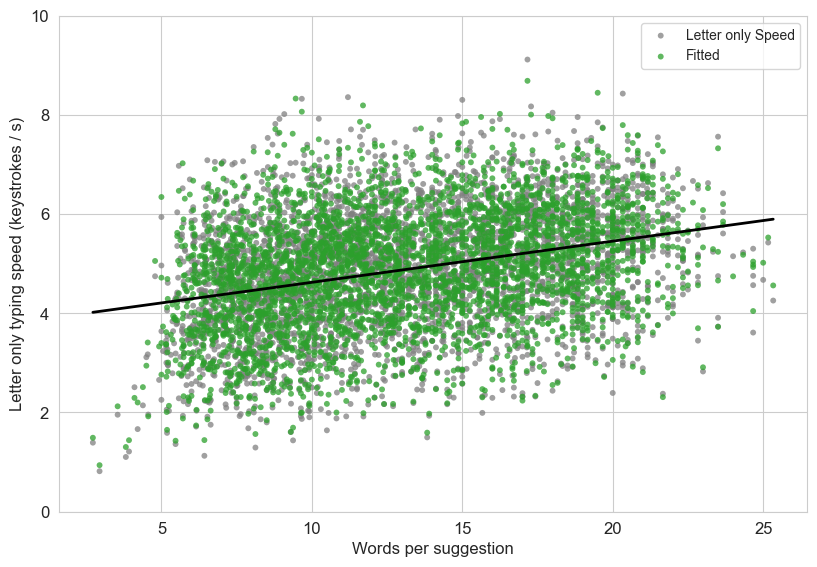

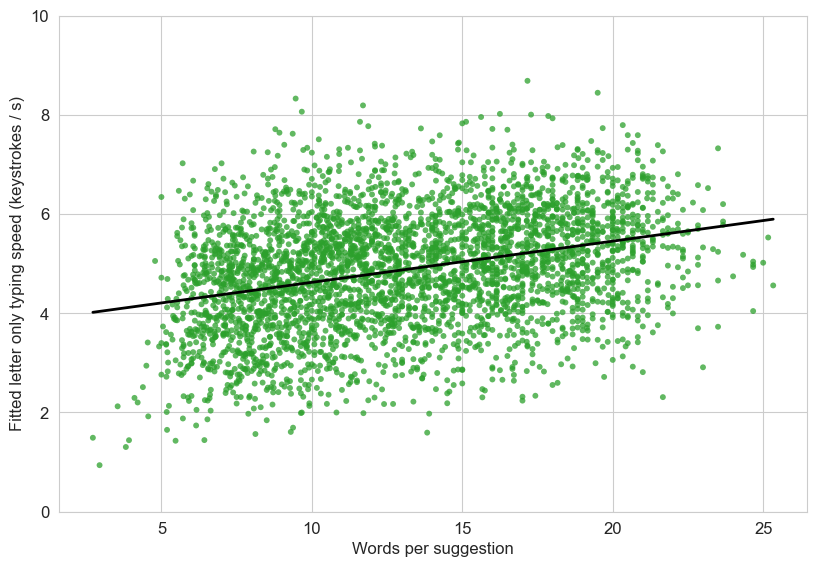

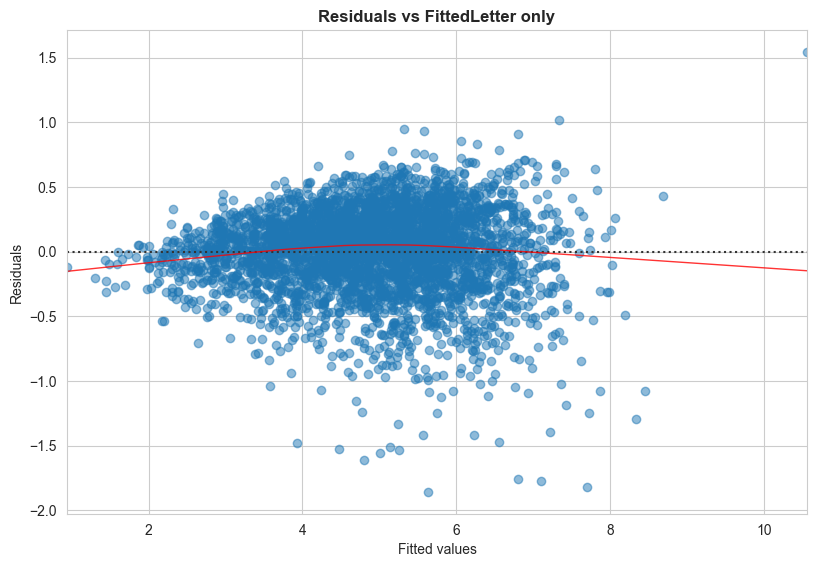

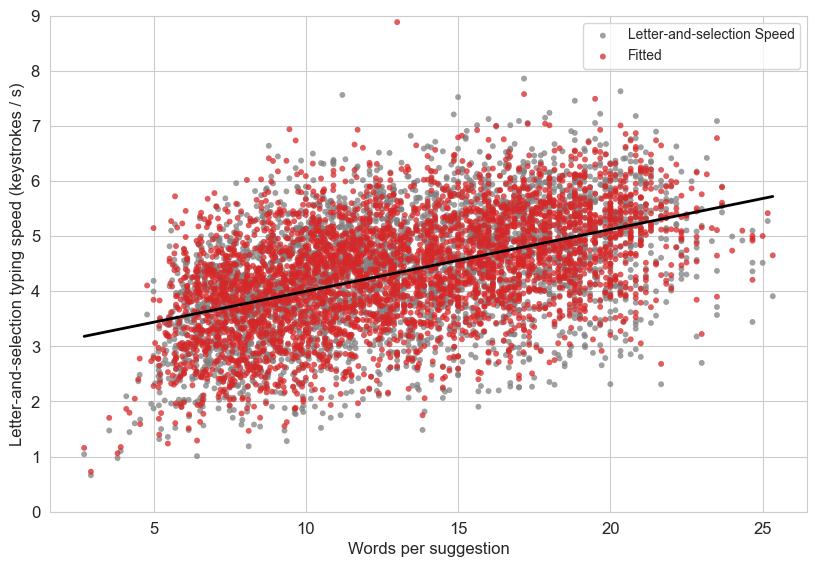

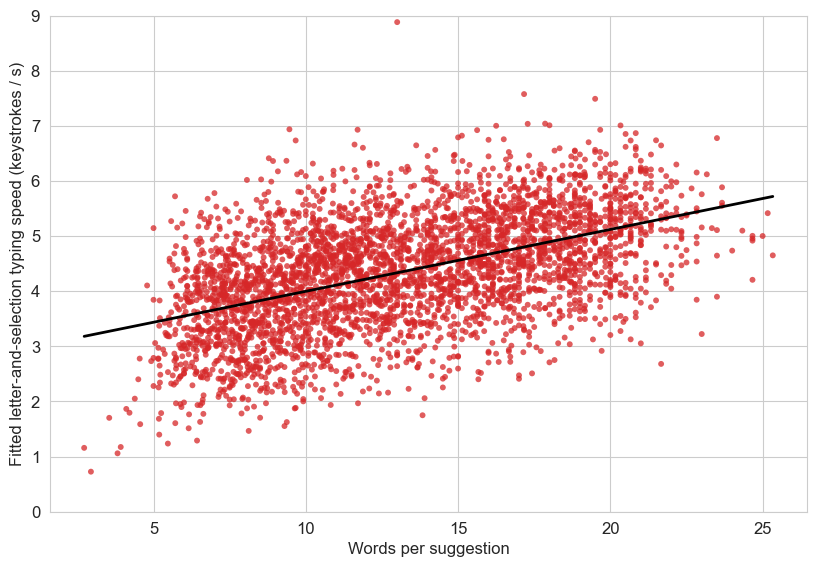

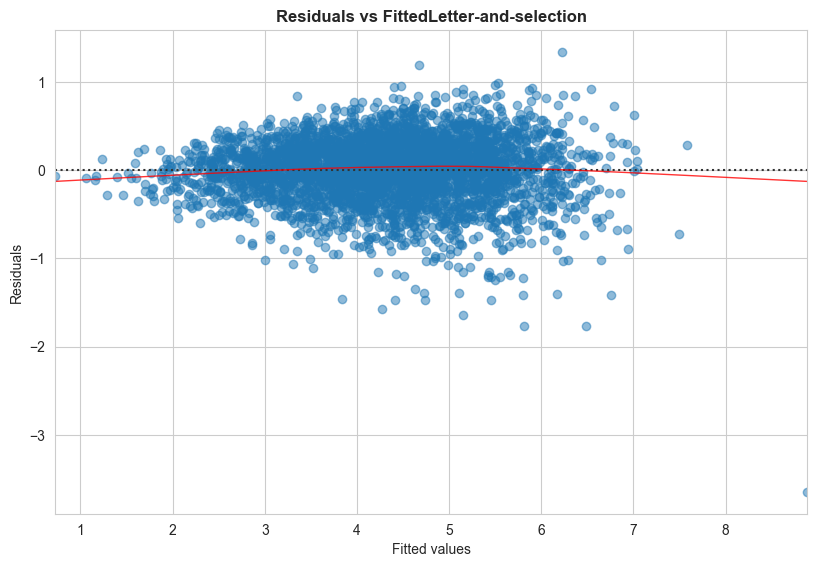

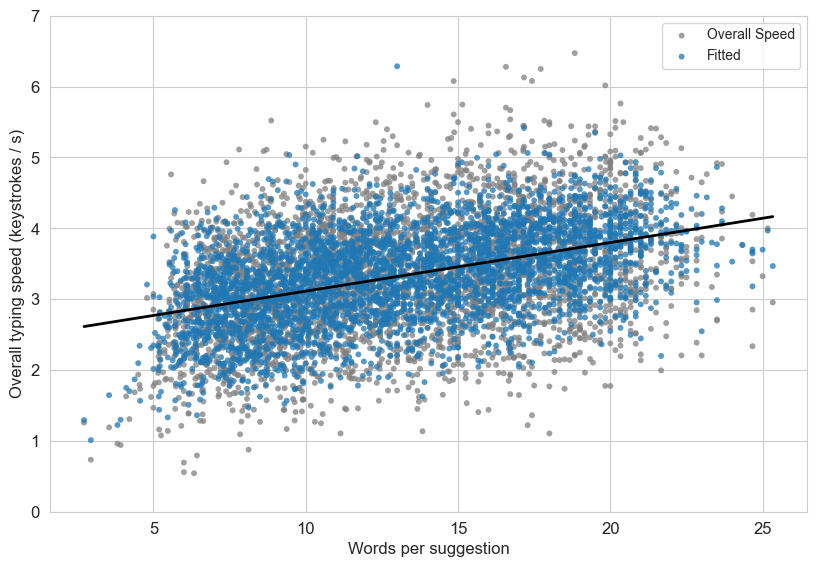

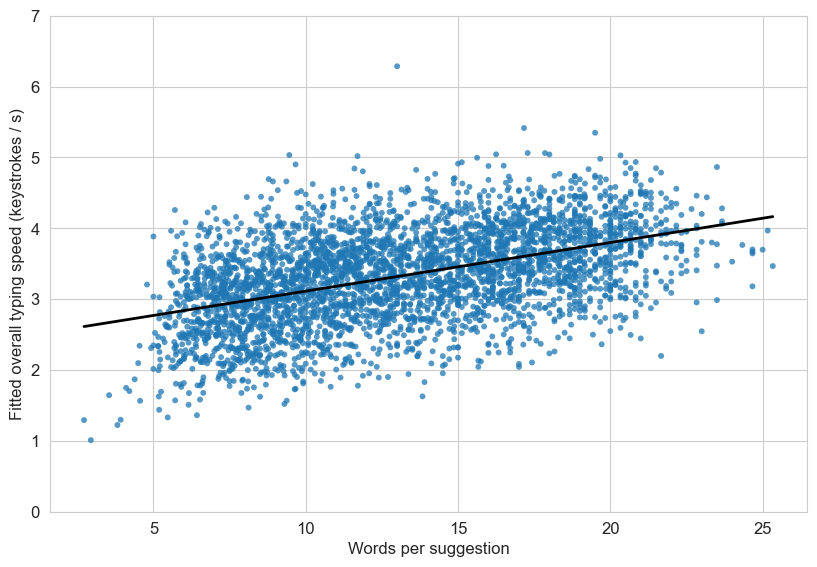

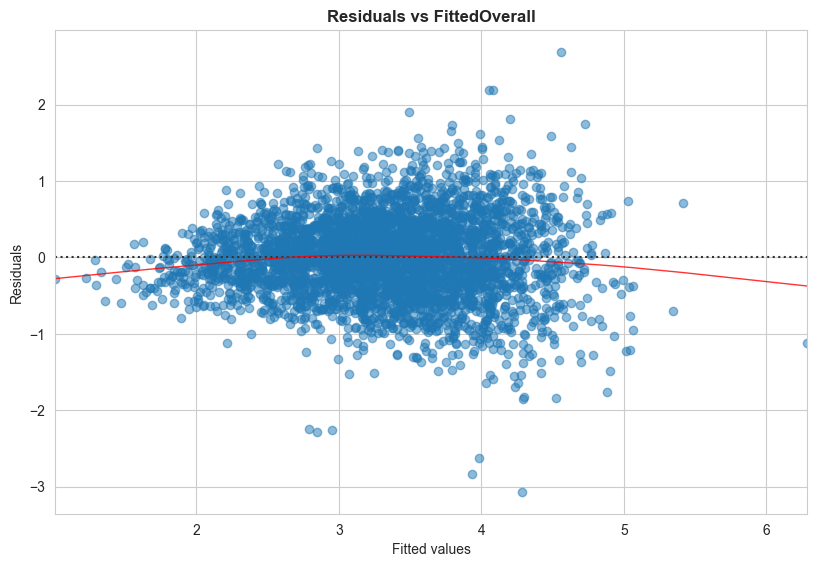

In [197]:
data = participants.loc[(participants.n_predict > 5) & (participants.n_predict < 20)].copy()
data.rate_predict = data.rate_predict.apply(np.reciprocal)
data.iki_natural = data.iki_natural.apply(np.reciprocal) * 1000

# For each type of IKI, perform an OLS
for i in ['letters', 'letters_and_ite', 'overall']:
    data = data.dropna(subset=['iki_' + i, 'rate_predict'])
    data['speed'] = data['iki_' + i].apply(np.reciprocal) * 1000 # Convert to speed
    
    X = data[['rate_predict', 'iki_natural']]
    X = sm.add_constant(X)
    y = data[['speed']]
    
    # OLS
    model = sm.OLS(y, X)
    results = model.fit()

    # scatter plot of raw and fitted values
    f,ax = plt.subplots(1, 1, figsize=(8, 5.5))
    ymax, color, label = vis_style.loc['speed_' + i].values
    sns.scatterplot(x=data['rate_predict'], y=data.speed, ax=ax, color="grey", alpha=0.75, s=18, edgecolor="none")
    sns.scatterplot(x=data['rate_predict'], y=results.fittedvalues, ax=ax, color=color, alpha=0.75, s=18, edgecolor="none")

    slope,intercept, r, p, std = stats.linregress(data.rate_predict, results.fittedvalues)
    xmin, xmax = data.rate_predict.min(), data.rate_predict.max()
    sns.lineplot(x=[xmin, xmax],y=[slope * xmin + intercept, slope * xmax + intercept], color='k', lw=2)

    #statsmodel visualization
    #sm.graphics.plot_fit(results, "rate_predict")

    ax.legend(labels=[label + " Speed", 'Fitted'])
    ax.set_ylim((0,ymax))
    ax.set_xlabel('Words per suggestion')
    ax.set_ylabel(label + ' typing speed (keystrokes / s)')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    ax.grid(True)
    f.tight_layout(pad=0.1)
    f.savefig('./figures/regression_fitted_and_raw-' + i + '_speed.png', dpi=300)

    # scatter plot of fitted values
    f,ax = plt.subplots(1, 1, figsize=(8, 5.5))
    ymax, color, label = vis_style.loc['speed_' + i].values
    sns.scatterplot(x=data['rate_predict'], y=results.fittedvalues, ax=ax, color=color, alpha=0.75, s=18, edgecolor="none", legend=False)

    slope,intercept, r, p, std = stats.linregress(data.rate_predict, results.fittedvalues)
    xmin, xmax = data.rate_predict.min(), data.rate_predict.max()
    sns.lineplot(x=[xmin, xmax],y=[slope * xmin + intercept, slope * xmax + intercept], color='k', lw=2)

    ax.set_ylim((0,ymax))
    ax.set_xlabel('Words per suggestion')
    ax.set_ylabel("Fitted " + label.lower() + ' typing speed (keystrokes / s)')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    ax.grid(True)
    f.tight_layout(pad=0.1)
    f.savefig('./figures/regression_fitted_for_natural_speed-' + i + '_speed.png',dpi=300)

    # residuals vs fitted plot
    # see: https://www.statsmodels.org/dev/examples/notebooks/generated/linear_regression_diagnostics_plots.html
    f,ax = plt.subplots(1, 1, figsize=(8,5.5))

    #fig = sm.graphics.plot_regress_exog(results, "iki_natural", f)

    sns.residplot(
        x=results.fittedvalues,
        y=results.resid,
        lowess=True,
        scatter_kws={'alpha': 0.5},
        line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
        ax=ax)

    ax.set_title('Residuals vs Fitted' + label, fontweight="bold")
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')
    f.tight_layout(pad=0.1)
    f.savefig('./figures/residuals_vs_fitted_' + i + '.png', dpi=300)

    # Print results
    print()
    print(i)
    #print(results.summary())
    print()
    print('slope: ',results.params[1])
    print('std: ', results.bse[1])
    print('p: ', results.pvalues[1])
    print('r2: ',results.rsquared)

Visualize the regression we just did for overall speed

In [199]:
# dataframe to hold results from linear regression
vis_data = pd.DataFrame(
    columns=['slope', 'std', 'p', 'r', 'intercept']
)

In [200]:
# Data prep
data = participants.loc[(participants.n_predict > 5) & (participants.n_predict < 20)].copy()
data['speed_overall'] = data.iki_overall.apply(np.reciprocal) * 1000
data['speed_natural'] = data.iki_natural.apply(np.reciprocal) * 1000
data['speed_letters'] = data.iki_letters.apply(np.reciprocal) * 1000
data['speed_letters_and_ite'] = data.iki_letters_and_ite.apply(np.reciprocal) * 1000
data.rate_predict = data.rate_predict.apply(np.reciprocal)

In [201]:
# OLS
for i in ['natural', 'letters', 'letters_and_ite', 'overall']:
    slope,intercept, r, p, std = stats.linregress(data.rate_predict, data['speed_'+i])
    vis_data.loc['speed_' + i] = [slope, std, p, r, intercept]
vis_data.head()

,slope,std,p,r,intercept
speed_natural,0.088830,0.004697,3.077065e-76,0.296469,4.284183
speed_letters,0.083064,0.004185,2.198593e-83,0.309715,3.793783
speed_letters_and_ite,0.112291,0.003465,4.696210e-203,0.469558,2.875965
speed_overall,0.068619,0.002868,9.012566e-118,0.365519,2.426465


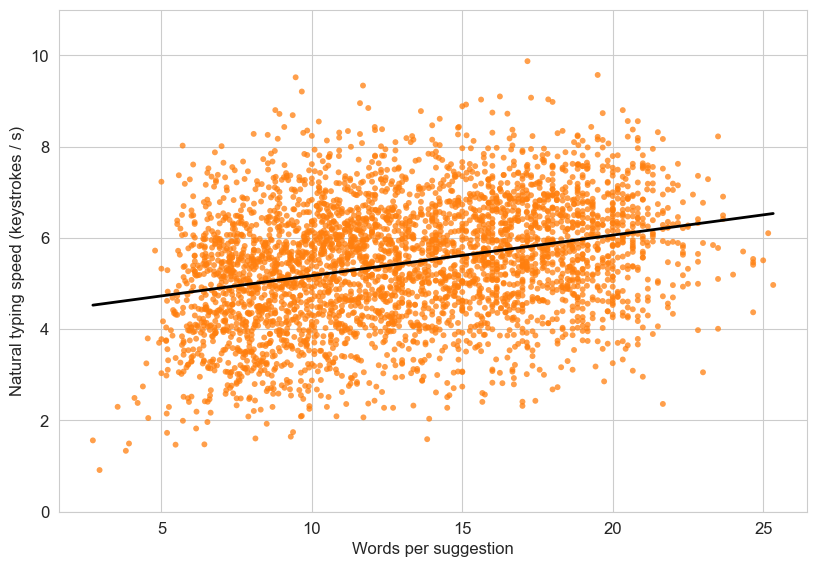

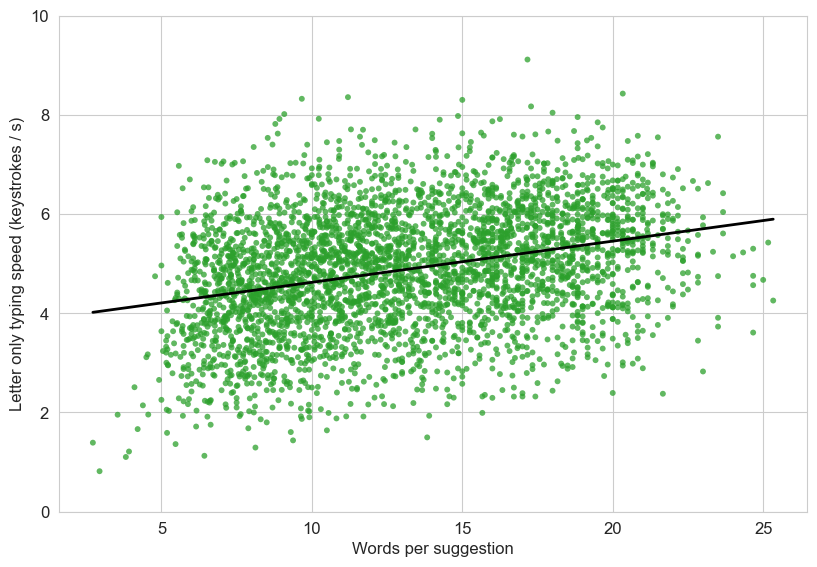

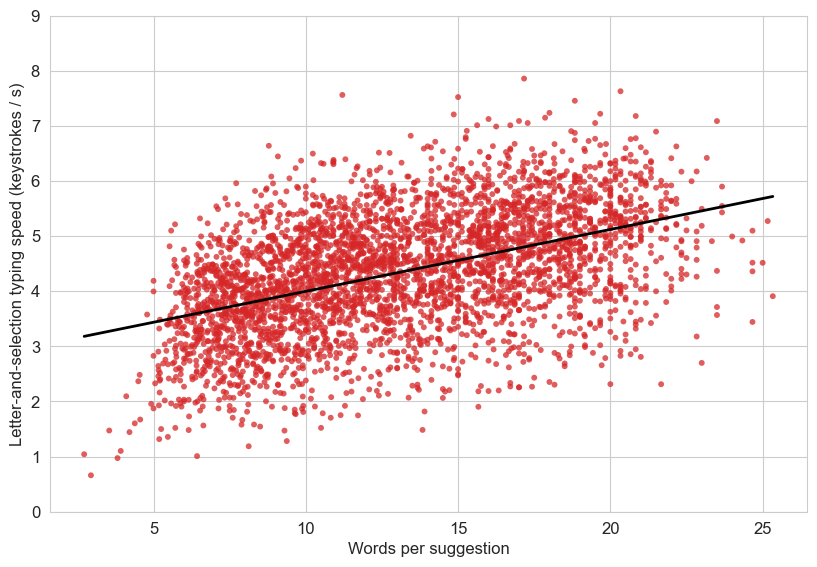

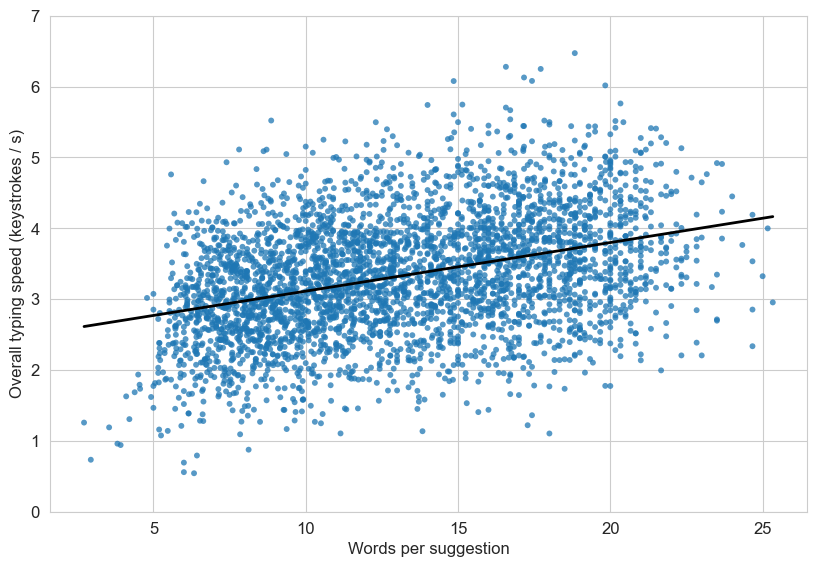

In [202]:
for i in ['natural', 'letters', 'letters_and_ite', 'overall']:
    f,ax = plt.subplots(1, 1, figsize=(8, 5.5))

    ymax, color, label = vis_style.loc['speed_' + i].values

    # Plot the points
    #sns.regplot(x=data['rate_predict'], y=data['speed_' + i], ax=ax, color=color, scatter_kws={'s': 5}, line_kws={'lw': 2, "color": 'black'})

    # scatter plot of fitted values
    sns.scatterplot(x=data['rate_predict'], y=data['speed_' + i], ax=ax, color=color, alpha=0.75, s=18, edgecolor="none", legend=False)

    slope, std, p, r, intercept = vis_data.loc['speed_' + i].values
    #slope,intercept, r, p, std = stats.linregress(data.rate_predict,data['speed_'+i])
    xmin, xmax = data.rate_predict.min(), data.rate_predict.max()
    sns.lineplot(x=[xmin, xmax],y=[slope * xmin + intercept, slope * xmax + intercept], color='k', lw=2)

    ax.set_ylim((0, ymax))
    ax.set_xlabel('Words per suggestion')
    ax.set_ylabel(label + ' typing speed (keystrokes / s)')

    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)

    ax.grid(True)

    f.tight_layout(pad=0.1)

    f.savefig('./figures/regression_' + i + '_speed.png', dpi=300)

### How does the extent of usage affect KPC?

In [288]:
# Data prep
mask = (participants.n_predict > 5) # Only look at suggestion users
mask &= (participants.n_predict < 26) # Exclude heavy usage (not enough data)
data = participants.loc[mask].copy()

X = data.rate_predict
X = sm.add_constant(X)
y = data.KPC

In [289]:
# OLS
model = sm.OLS(y, X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    KPC   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     3773.
Date:                Wed, 19 Apr 2023   Prob (F-statistic):               0.00
Time:                        21:03:21   Log-Likelihood:                 10444.
No. Observations:                4032   AIC:                        -2.088e+04
Df Residuals:                    4030   BIC:                        -2.087e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.9934      0.001   1472.659      0.000       0.992       0.995
rate_predict    -0.3923      0.006    -61.425      0.000      -0.405      -0.380
==============================================================================
Omnibus:                     2825.244   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           175810.371
Skew:                          -2.689   Prob(JB):                         0.00
Kurtosis:                      34.899   Cond. No.                         22.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

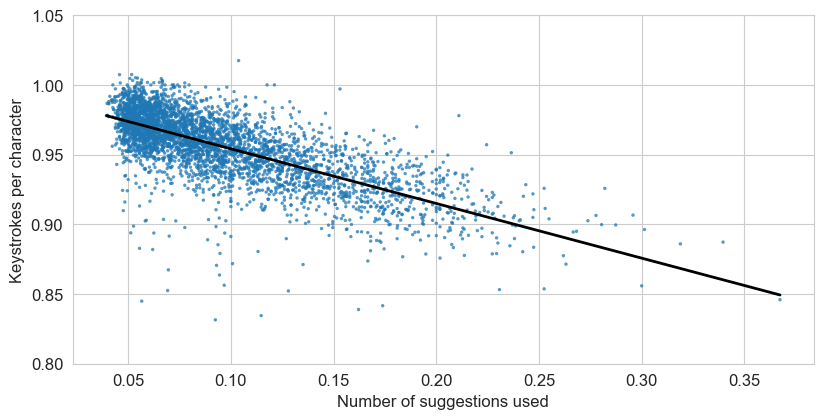

In [290]:
f,ax = plt.subplots(1, 1, figsize=(8, 4))

# Plot the points
ax = sns.scatterplot(x=data.rate_predict, y=data.KPC, color="C0", alpha=0.75, s=6, edgecolor="none",)

# Plot the regression line
xmin = X.min()[1]
xmax = X.max()[1]
intercept, slope = results.params[0], results.params[1]
sns.lineplot(x=[xmin, xmax], y=[slope * xmin + intercept, slope * xmax + intercept], color='k',lw=2)

ax.set(ylim=(0.80, 1.05))
ax.set_xlabel('Number of suggestions used')
ax.set_ylabel('Keystrokes per character')

f.tight_layout(pad=0.1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                  ax.get_xticklabels() + ax.get_yticklabels()):
         item.set_fontsize(12)

f.savefig('./figures/regression_kpc.png',dpi=300)